In [29]:
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, accuracy_score

from proj2.config import HEART_DATA_FILE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Add, Activation
from tensorflow.keras.optimizers import Adam


import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

### Data Import

In [60]:
import pandas as pd

df = pd.read_csv(HEART_DATA_FILE)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Q1 - Data Exploration

#### Feature Overview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


#### Check Missing Values & Data Types

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


#### Class Distribution

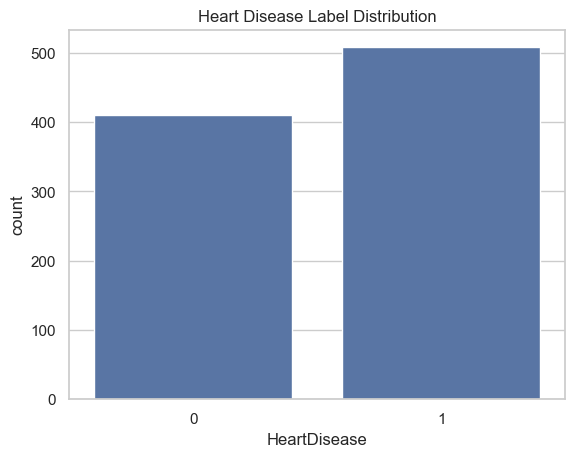

HeartDisease
1    55.337691
0    44.662309
Name: proportion, dtype: float64

#### Distribution of Numerical Features

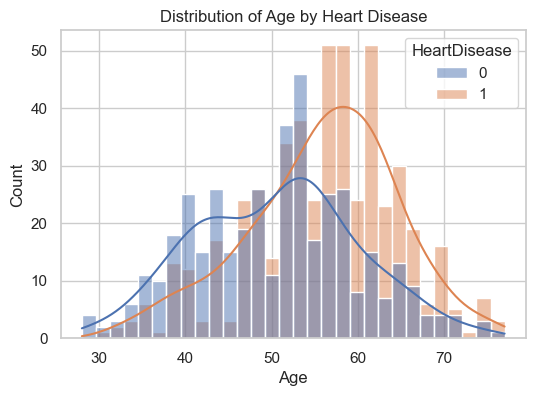

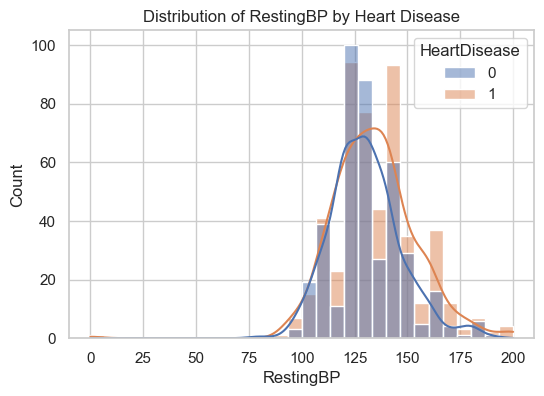

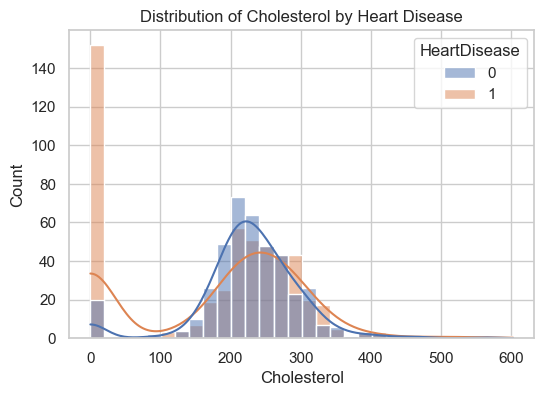

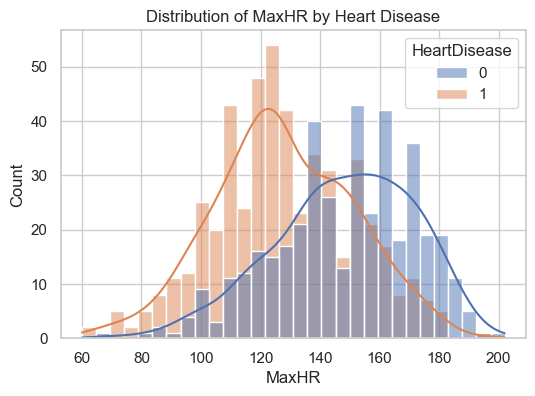

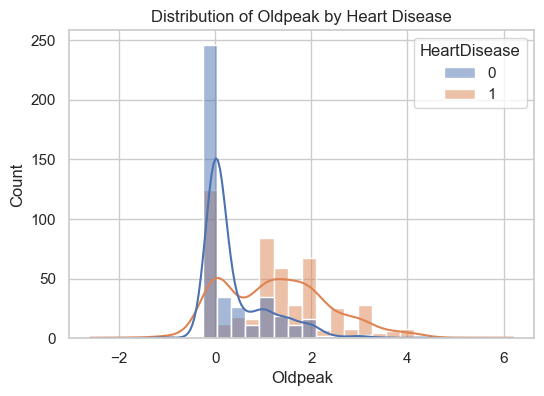

In [63]:
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df, x=col, hue="HeartDisease", kde=True, bins=30)
    plt.title(f'Distribution of {col} by Heart Disease')
    plt.show()

In [55]:
age_means = df.groupby('HeartDisease')['Age'].mean()

mean_disease   = age_means.loc[1]
mean_no_disease = age_means.loc[0]

print(
    f"Age: Patients with heart disease are on average older "
    f"(mean = {mean_disease:.2f}) than those without "
    f"(mean = {mean_no_disease:.2f}), and the density peak shifts right."
)

Age: Patients with heart disease are on average older (mean = 55.90) than those without (mean = 50.55), and the density peak shifts right.


#### Outliers

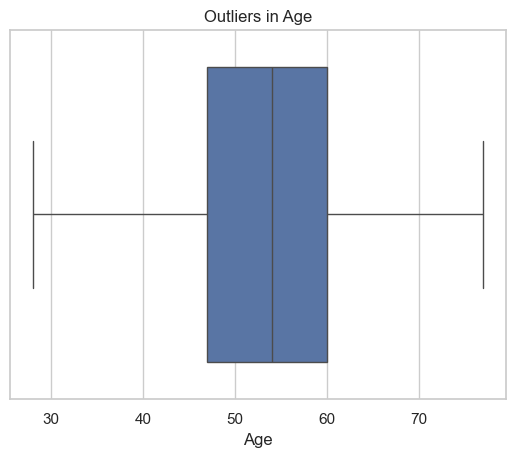

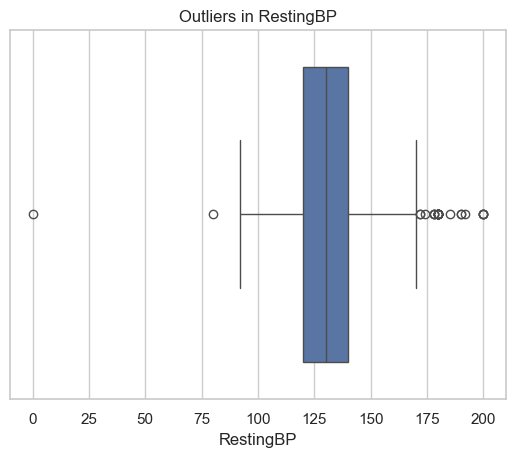

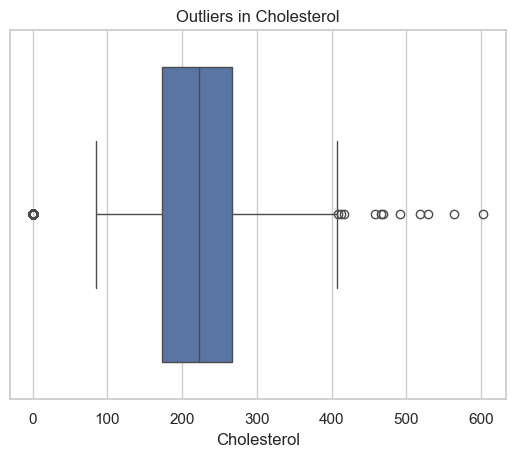

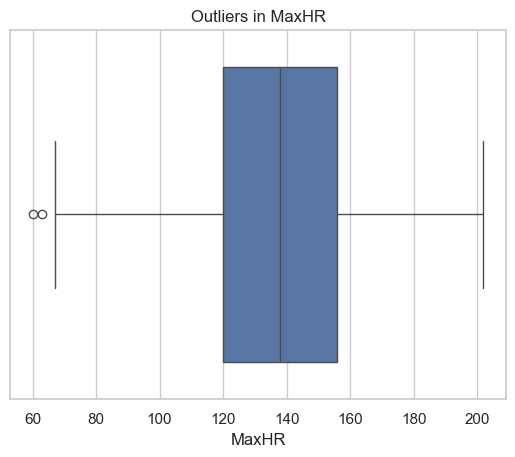

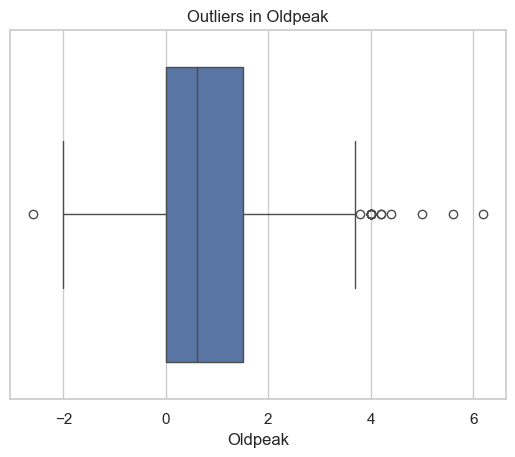

Unrealistic Cholesterol values: 13


Unrealistic Oldpeak values: 13


In [38]:
print(f"Unrealistic RestingHB values: {len(df[df['RestingBP'] == 0])}")

Unrealistic RestingHB values: 1


#### Categorical Feature Counts

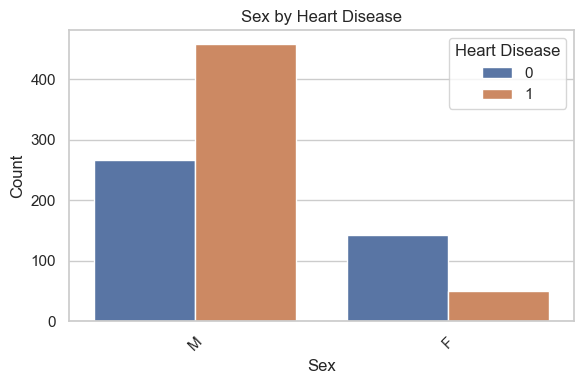

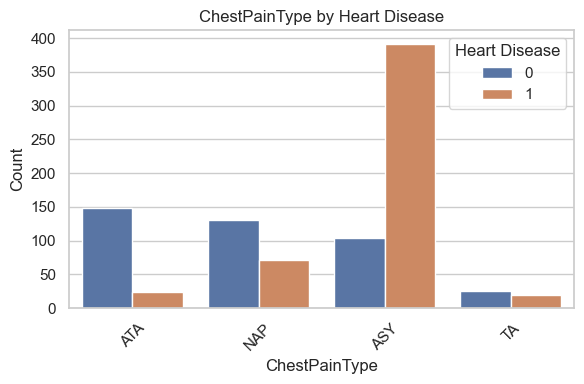

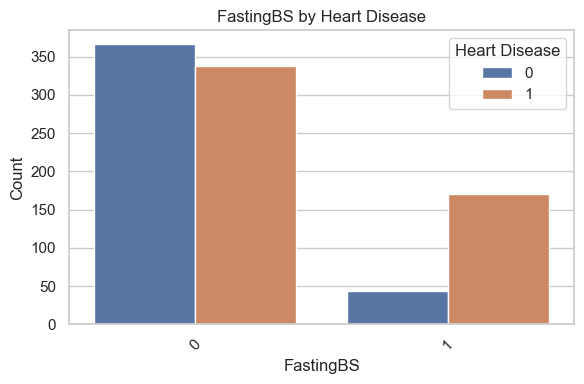

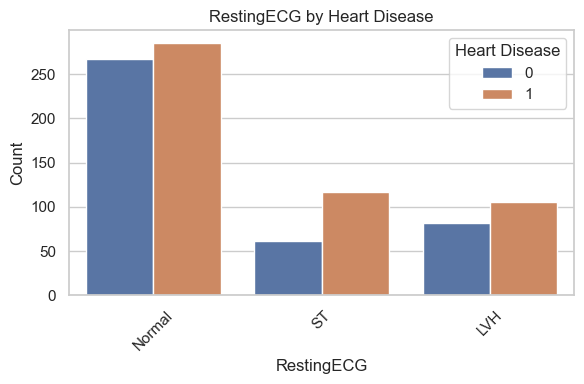

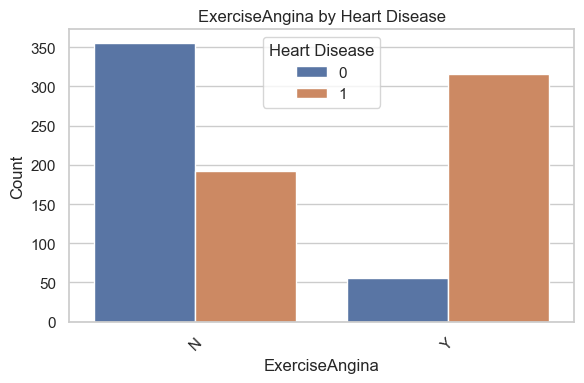

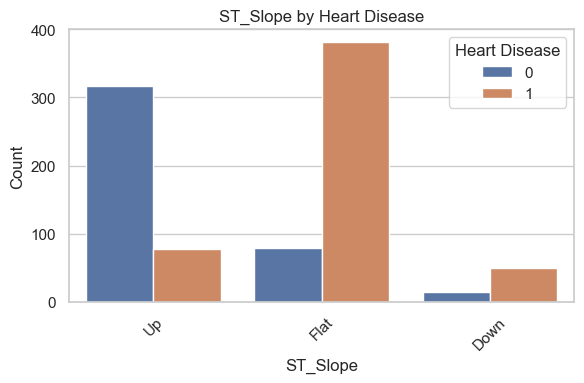

In [64]:
cat_cols = ['Sex', 'ChestPainType', 'FastingBS','RestingECG', 'ExerciseAngina', 'ST_Slope']

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue='HeartDisease')
    plt.title(f"{col} by Heart Disease")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title="Heart Disease")
    plt.tight_layout()
    plt.show()

## Q1.3 - Data Preprocessing

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,RestingECG_Normal,RestingECG_ST,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
0,40,1,140,289,0,172,0,0.0,2.0,0,True,False,True,False,False
1,49,0,160,180,0,156,0,1.0,1.0,1,True,False,False,True,False
2,37,1,130,283,0,98,0,0.0,2.0,0,False,True,True,False,False
3,48,0,138,214,0,108,1,1.5,1.0,1,True,False,False,False,False
4,54,1,150,195,0,122,0,0.0,2.0,0,True,False,False,True,False


#### Impute Nonsensical Values

In [41]:
df_imputation = df_encoded.copy()
df_imputation['Cholesterol'] = df_imputation['Cholesterol'].replace(0, np.nan)
df_imputation['RestingBP'] = df_imputation['RestingBP'].replace(0, np.nan)

imputer = KNNImputer(n_neighbors=5)
df_imputation_array = imputer.fit_transform(df_imputation)
df_imputation = pd.DataFrame(df_imputation_array, columns=df_imputation.columns)


In [58]:
df_imputation.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST
0,40.0,1.0,140.0,289.0,0.0,172.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
1,49.0,0.0,160.0,180.0,0.0,156.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,37.0,1.0,130.0,283.0,0.0,98.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0
3,48.0,0.0,138.0,214.0,0.0,108.0,1.0,1.5,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,54.0,1.0,150.0,195.0,0.0,122.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0


#### Outlier handeling

In [43]:
q99 = df_imputation['Cholesterol'].quantile(0.99)
df_imputation['Cholesterol'] = np.where(df_imputation['Cholesterol'] > q99, q99, df_imputation['Cholesterol'])

In [44]:
df_imputation['Oldpeak'] = df_imputation['Oldpeak'].apply(lambda x: 0 if x < 0 else x)

In [46]:
# Feature scaling
features = df_imputation.drop("HeartDisease", axis=1)
target = df_imputation["HeartDisease"]

#scaler = StandardScaler()
#features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)
X = df_imputation.drop("HeartDisease", axis=1)

---

# Q2 - Logistic Lasso Regression
#### Fit Lasso Logistic Model

In [71]:
# L1-regularized logistic regression (Lasso)
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
lasso_model.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear') In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. LogisticRegression ? Documentation for LogisticRegression i Fitted LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

## Q2.2 TO CHECK
The preprocessing steps which are crucial are the imputing, since otherwise we can not feed the model with data, outlier handling, since otherwise the generalization is less stable, and finally the standardization, since the magnitude might make the model less precise.

---

## Q2.3

#### Performance 

In [72]:
y_pred = lasso_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1:.3f}")
print(f"Balanced Accuracy: {balanced_acc:.3f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


F1 Score: 0.886
Balanced Accuracy: 0.864

Classification Report:

              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85        82
         1.0       0.86      0.91      0.89       102

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184



---
## Q2.4

#### Visualization of Feature Importance

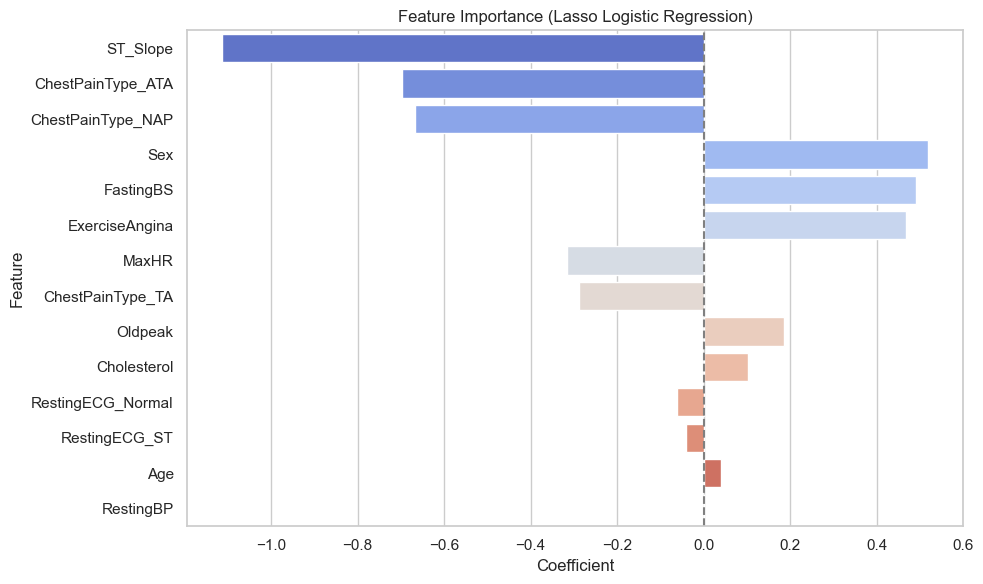

In [67]:
# Get feature names and corresponding coefficients
feature_names = features.columns
coefficients = lasso_model.coef_[0]

# Create a DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
# Sort by absolute importance
coef_df = coef_df.sort_values(by="Coefficient", key=lambda x: np.abs(x), ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='coolwarm')
plt.title("Feature Importance (Lasso Logistic Regression)")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

---

## Q2.5 In the overleaf 
Refitting a standard logistic regression on Lasso‐selected variables may yield a simpler model, but it breaks formal statistical inference. In a purely predictive ML setting, you could choose whichever model maximizes cross‐validated accuracy. However, for statistical interpretation and hypothesis testing, this two‐stage approach invalidates p‐values and confidence intervals because it ignores the uncertainty introduced by feature selection. Moreover, Lasso can drop genuine confounders under penalty, biasing coefficients in the refit. So overall it is recommended to use the full lasso model.

---
# Q3 - Multi-Layer Perceptrons
### Q3.1 - MLP Training

In [22]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.1, epochs=30, batch_size=32, verbose=0)


#### Evaluation

In [18]:
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

print("F1 Score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
F1 Score: 0.8712871287128713
Accuracy: 0.8586956521739131
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84        82
         1.0       0.88      0.86      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



---
### Q3.2 - SHAP Explanations

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
F1 Score: 0.8823529411764706
Accuracy: 0.8695652173913043
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85        82
         1.0       0.88      0.88      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



#### SHAP Explanations

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 734 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/4 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 44s 934us/step


 25%|██▌       | 1/4 [01:04<03:13, 64.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 39s 820us/step


 50%|█████     | 2/4 [01:56<01:54, 57.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 40s 830us/step


 75%|███████▌  | 3/4 [02:49<00:55, 55.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 54s 1ms/step


100%|██████████| 4/4 [03:56<00:00, 59.01s/it]


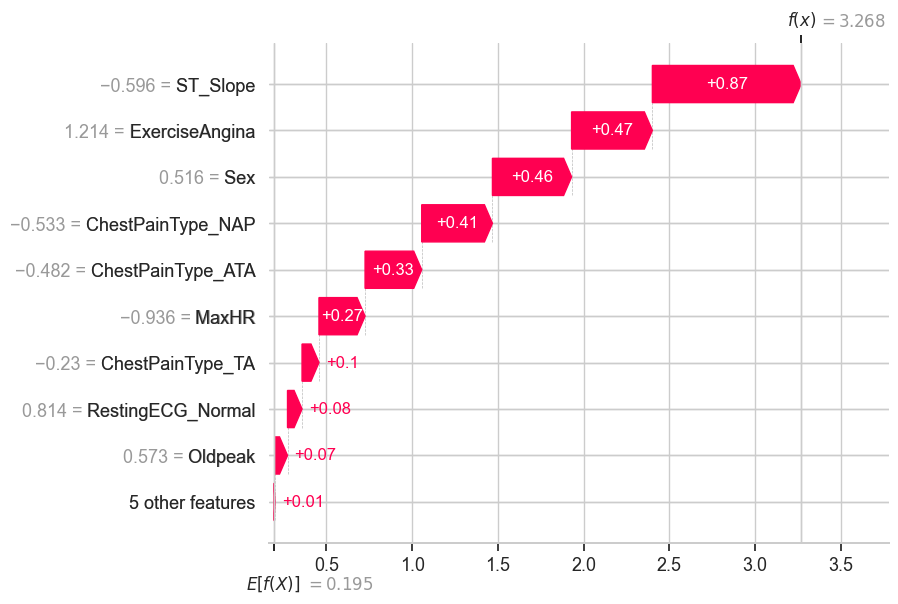

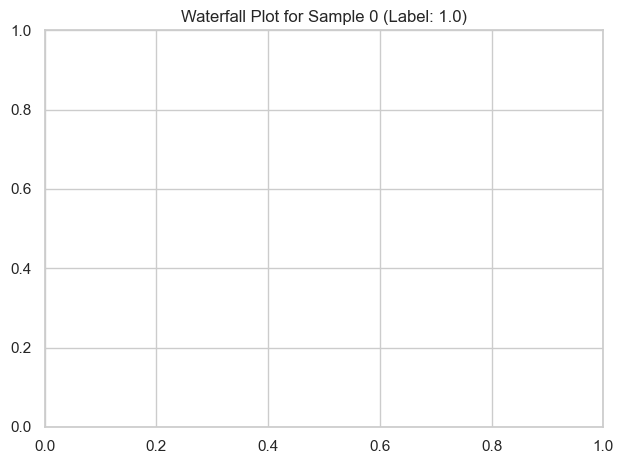

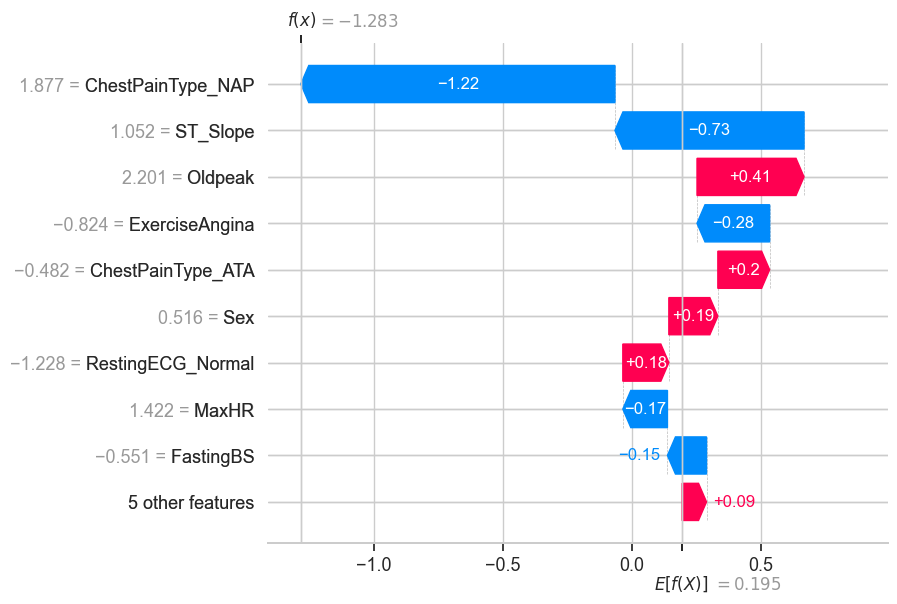

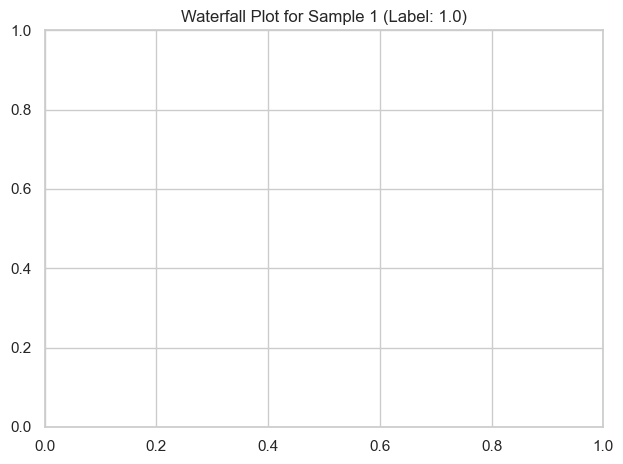

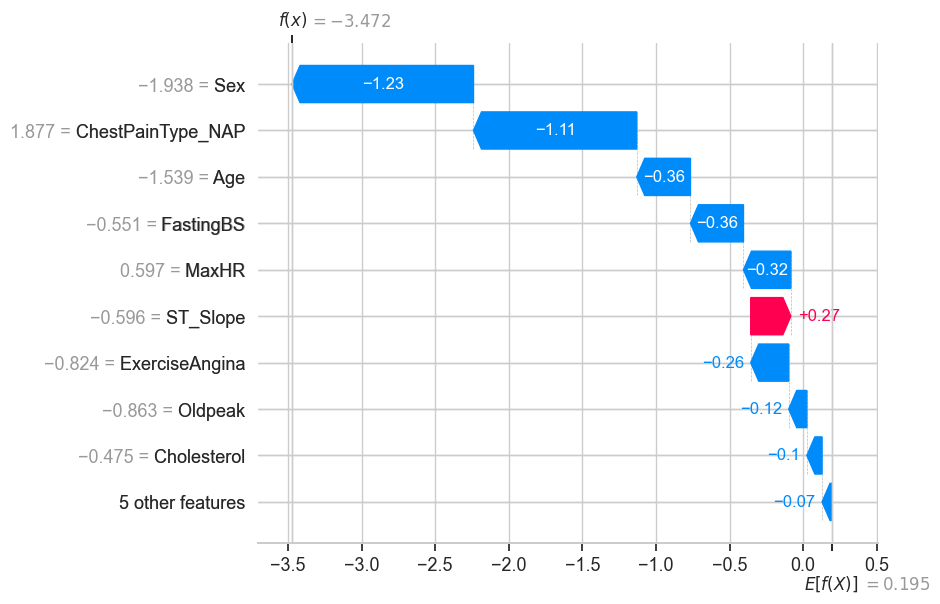

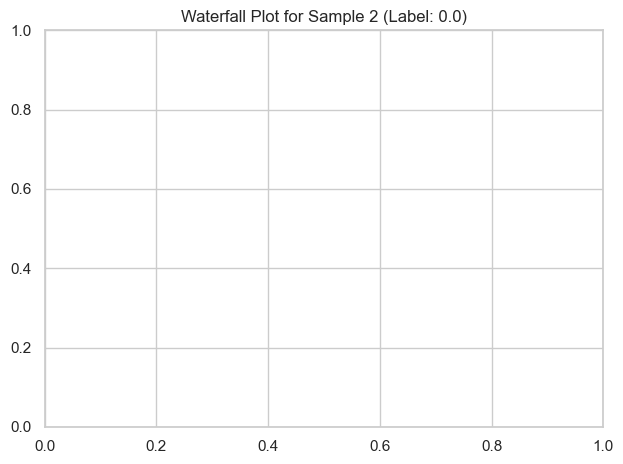

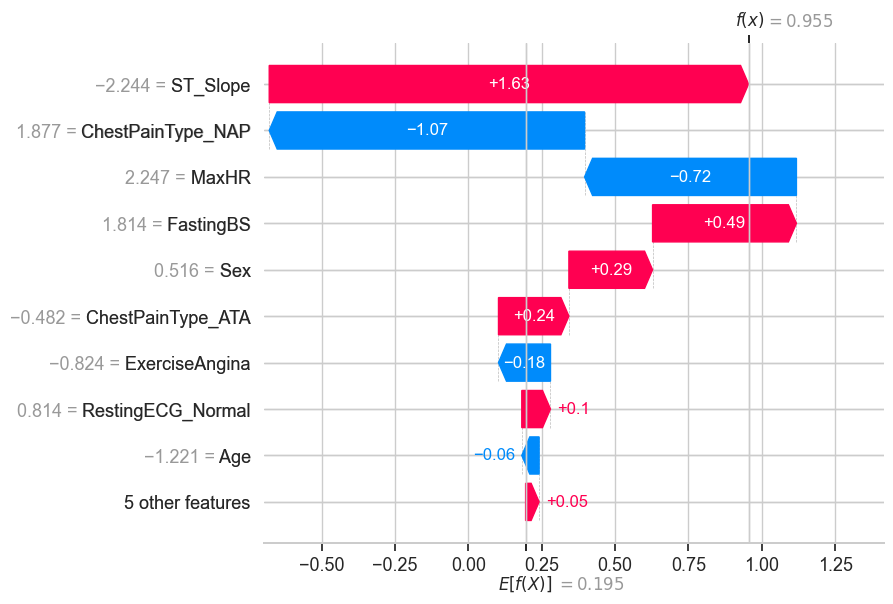

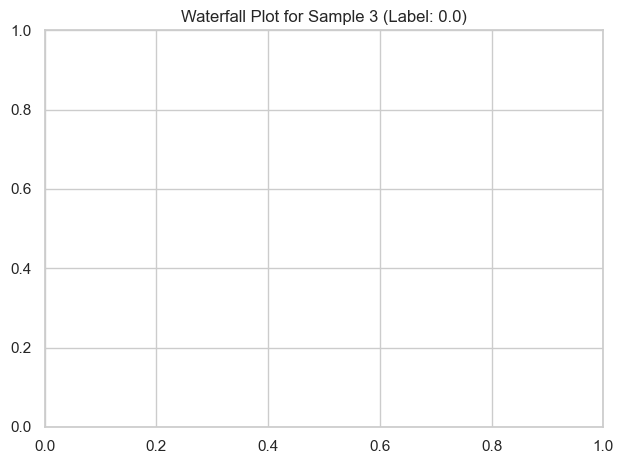

In [24]:
# 1) wrap model.predict to return flat probabilities
predict_proba_fn = lambda X: model.predict(X).ravel()

# 2) create SHAP KernelExplainer
explainer = shap.KernelExplainer(
    predict_proba_fn,
    X_train,
    link="logit"
)

# 3) select 2 positive and 2 negative samples
pos_idx = np.where(y_test.values == 1)[0][:2]
neg_idx = np.where(y_test.values == 0)[0][:2]
sample_indices = np.concatenate([pos_idx, neg_idx])
X_sample = X_test[sample_indices]

# 4) compute SHAP values
shap_values = explainer.shap_values(X_sample)

# 5) unpack values if KernelExplainer returns a list
if isinstance(shap_values, list):
    shap_vals = shap_values[0]
    base_val = explainer.expected_value[0]
else:
    shap_vals = shap_values
    base_val = explainer.expected_value

# 6) plot SHAP waterfall for each sample
for i in range(X_sample.shape[0]):
    expl = shap.Explanation(
        values=shap_vals[i],
        base_values=base_val,
        data=X_sample[i],
        feature_names=X.columns
    )
    shap.plots.waterfall(expl)
    plt.title(f"Waterfall Plot for Sample {i} (Label: {y_test.values[sample_indices[i]]})")
    plt.tight_layout()
    plt.show()
    

The SHAP force plots for the four selected samples show varying feature contributions depending on the prediction. For the two positive predictions (with high output log-odds of ~3.24 and 1.03), key contributing features include ST_Slope, ExerciseAngina, and FastingBS, which pushed the model strongly toward predicting the presence of heart disease. In contrast, the two negative predictions (with log-odds ~–1.71 and –3.55) were heavily influenced by features such as ChestPainType_ATA, Sex, and MaxHR, which decreased the likelihood of a positive outcome. Notably, ChestPainType_ATA consistently acted as a strong negative contributor, while ST_Slope and ExerciseAngina were the most impactful positive contributors across samples. This highlights that while some features are consistently important, their effects can vary in direction and magnitude depending on the patient profile.

  0%|          | 0/184 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step


  1%|          | 1/184 [01:29<4:33:27, 89.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 32s 667us/step


  1%|          | 2/184 [02:09<3:02:32, 60.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 479us/step


  2%|▏         | 3/184 [02:39<2:20:15, 46.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 489us/step


  2%|▏         | 4/184 [03:10<2:01:15, 40.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 24s 495us/step


  3%|▎         | 5/184 [03:41<1:50:29, 37.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 475us/step


  3%|▎         | 6/184 [04:11<1:42:56, 34.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 468us/step


  4%|▍         | 7/184 [04:41<1:37:38, 33.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 486us/step


  4%|▍         | 8/184 [05:12<1:34:50, 32.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 492us/step


  5%|▍         | 9/184 [05:43<1:33:00, 31.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 24s 513us/step


  5%|▌         | 10/184 [06:15<1:32:58, 32.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 484us/step


  6%|▌         | 11/184 [06:46<1:31:12, 31.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 24s 495us/step


  7%|▋         | 12/184 [07:17<1:29:56, 31.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 426us/step


  7%|▋         | 13/184 [07:44<1:26:00, 30.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 424us/step


  8%|▊         | 14/184 [08:12<1:23:18, 29.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 429us/step


  8%|▊         | 15/184 [08:39<1:21:19, 28.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 427us/step


  9%|▊         | 16/184 [09:07<1:19:46, 28.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 416us/step


  9%|▉         | 17/184 [09:34<1:17:54, 27.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 414us/step


 10%|▉         | 18/184 [10:00<1:16:24, 27.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 418us/step


 10%|█         | 19/184 [10:27<1:15:17, 27.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 420us/step


 11%|█         | 20/184 [10:54<1:14:31, 27.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 439us/step


 11%|█▏        | 21/184 [11:22<1:14:38, 27.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 419us/step


 12%|█▏        | 22/184 [11:49<1:13:44, 27.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 416us/step


 12%|█▎        | 23/184 [12:16<1:12:48, 27.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 417us/step


 13%|█▎        | 24/184 [12:43<1:12:25, 27.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 475us/step


 14%|█▎        | 25/184 [13:13<1:14:02, 27.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 468us/step


 14%|█▍        | 26/184 [13:42<1:14:33, 28.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 428us/step


 15%|█▍        | 27/184 [14:09<1:13:19, 28.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 413us/step


 15%|█▌        | 28/184 [14:36<1:11:50, 27.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 414us/step


 16%|█▌        | 29/184 [15:03<1:10:51, 27.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 444us/step


 16%|█▋        | 30/184 [15:31<1:11:08, 27.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 465us/step


 17%|█▋        | 31/184 [16:01<1:11:57, 28.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 468us/step


 17%|█▋        | 32/184 [16:30<1:12:15, 28.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 412us/step


 18%|█▊        | 33/184 [16:57<1:10:23, 27.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 414us/step


 18%|█▊        | 34/184 [17:23<1:08:55, 27.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 415us/step


 19%|█▉        | 35/184 [17:50<1:07:46, 27.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 435us/step


 20%|█▉        | 36/184 [18:18<1:07:47, 27.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 436us/step


 20%|██        | 37/184 [18:46<1:07:34, 27.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 426us/step


 21%|██        | 38/184 [19:13<1:07:12, 27.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 447us/step


 21%|██        | 39/184 [19:42<1:07:16, 27.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 415us/step


 22%|██▏       | 40/184 [20:09<1:06:04, 27.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 465us/step


 22%|██▏       | 41/184 [20:38<1:06:47, 28.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 428us/step


 23%|██▎       | 42/184 [21:06<1:06:07, 27.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 418us/step


 23%|██▎       | 43/184 [21:32<1:04:57, 27.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 418us/step


 24%|██▍       | 44/184 [21:59<1:03:54, 27.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 415us/step


 24%|██▍       | 45/184 [22:26<1:03:01, 27.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 419us/step


 25%|██▌       | 46/184 [22:53<1:02:31, 27.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 463us/step


 26%|██▌       | 47/184 [23:22<1:03:20, 27.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 416us/step


 26%|██▌       | 48/184 [23:49<1:02:25, 27.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 466us/step


 27%|██▋       | 49/184 [24:18<1:03:02, 28.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 418us/step


 27%|██▋       | 50/184 [24:45<1:01:45, 27.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 480us/step


 28%|██▊       | 51/184 [25:15<1:02:53, 28.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 447us/step


 28%|██▊       | 52/184 [25:44<1:02:22, 28.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 412us/step


 29%|██▉       | 53/184 [26:10<1:00:43, 27.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 461us/step


 29%|██▉       | 54/184 [26:39<1:01:05, 28.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 421us/step


 30%|██▉       | 55/184 [27:06<59:56, 27.88s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 420us/step


 30%|███       | 56/184 [27:33<58:51, 27.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 417us/step


 31%|███       | 57/184 [28:00<57:52, 27.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 432us/step


 32%|███▏      | 58/184 [28:28<57:47, 27.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 471us/step


 32%|███▏      | 59/184 [28:58<58:39, 28.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 476us/step


 33%|███▎      | 60/184 [29:28<59:19, 28.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 450us/step


 33%|███▎      | 61/184 [29:56<58:39, 28.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 414us/step


 34%|███▎      | 62/184 [30:23<56:58, 28.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 469us/step


 34%|███▍      | 63/184 [30:52<57:29, 28.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 478us/step


 35%|███▍      | 64/184 [31:22<57:56, 28.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 474us/step


 35%|███▌      | 65/184 [31:52<57:53, 29.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 457us/step


 36%|███▌      | 66/184 [32:21<57:18, 29.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 416us/step


 36%|███▋      | 67/184 [32:48<55:29, 28.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 417us/step


 37%|███▋      | 68/184 [33:15<54:01, 27.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 417us/step


 38%|███▊      | 69/184 [33:42<52:56, 27.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 437us/step


 38%|███▊      | 70/184 [34:10<52:41, 27.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 458us/step


 39%|███▊      | 71/184 [34:38<52:48, 28.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 420us/step


 39%|███▉      | 72/184 [35:05<51:50, 27.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 478us/step


 40%|███▉      | 73/184 [35:35<52:31, 28.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 480us/step


 40%|████      | 74/184 [36:05<52:47, 28.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 432us/step


 41%|████      | 75/184 [36:33<51:41, 28.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 419us/step


 41%|████▏     | 76/184 [37:00<50:24, 28.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 457us/step


 42%|████▏     | 77/184 [37:29<50:26, 28.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 418us/step


 42%|████▏     | 78/184 [37:56<49:16, 27.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 422us/step


 43%|████▎     | 79/184 [38:23<48:23, 27.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 422us/step


 43%|████▎     | 80/184 [38:50<47:37, 27.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 451us/step


 44%|████▍     | 81/184 [39:18<47:45, 27.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 436us/step


 45%|████▍     | 82/184 [39:46<47:17, 27.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 425us/step


 45%|████▌     | 83/184 [40:14<46:36, 27.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 458us/step


 46%|████▌     | 84/184 [40:42<46:43, 28.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 420us/step


 46%|████▌     | 85/184 [41:09<45:45, 27.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 473us/step


 47%|████▋     | 86/184 [41:39<46:15, 28.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 424us/step


 47%|████▋     | 87/184 [42:06<45:12, 27.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 415us/step


 48%|████▊     | 88/184 [42:33<44:10, 27.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 421us/step


 48%|████▊     | 89/184 [43:00<43:29, 27.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 431us/step


 49%|████▉     | 90/184 [43:28<43:13, 27.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 441us/step


 49%|████▉     | 91/184 [43:56<42:58, 27.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 416us/step


 50%|█████     | 92/184 [44:23<42:11, 27.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 464us/step


 51%|█████     | 93/184 [44:52<42:29, 28.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 414us/step


 51%|█████     | 94/184 [45:19<41:23, 27.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 422us/step


 52%|█████▏    | 95/184 [45:46<40:41, 27.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 420us/step


 52%|█████▏    | 96/184 [46:13<40:01, 27.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 446us/step


 53%|█████▎    | 97/184 [46:41<40:07, 27.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 435us/step


 53%|█████▎    | 98/184 [47:09<39:43, 27.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 421us/step


 54%|█████▍    | 99/184 [47:36<39:00, 27.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 410us/step


 54%|█████▍    | 100/184 [48:03<38:11, 27.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 473us/step


 55%|█████▍    | 101/184 [48:33<38:38, 27.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 418us/step


 55%|█████▌    | 102/184 [48:59<37:42, 27.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 424us/step


 56%|█████▌    | 103/184 [49:26<37:05, 27.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 410us/step


 57%|█████▋    | 104/184 [49:53<36:13, 27.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 444us/step


 57%|█████▋    | 105/184 [50:21<36:16, 27.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 479us/step


 58%|█████▊    | 106/184 [50:52<36:51, 28.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 24s 499us/step


 58%|█████▊    | 107/184 [51:22<37:21, 29.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 414us/step


 59%|█████▊    | 108/184 [51:49<35:59, 28.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 421us/step


 59%|█████▉    | 109/184 [52:16<35:00, 28.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 416us/step


 60%|█████▉    | 110/184 [52:43<34:03, 27.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 445us/step


 60%|██████    | 111/184 [53:11<33:53, 27.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 431us/step


 61%|██████    | 112/184 [53:39<33:20, 27.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 437us/step


 61%|██████▏   | 113/184 [54:07<32:58, 27.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 441us/step


 62%|██████▏   | 114/184 [54:35<32:35, 27.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 423us/step


 62%|██████▎   | 115/184 [55:03<31:56, 27.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 463us/step


 63%|██████▎   | 116/184 [55:32<31:54, 28.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 433us/step


 64%|██████▎   | 117/184 [55:59<31:14, 27.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 462us/step


 64%|██████▍   | 118/184 [56:28<31:10, 28.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 418us/step


 65%|██████▍   | 119/184 [56:55<30:14, 27.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 414us/step


 65%|██████▌   | 120/184 [57:22<29:24, 27.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 421us/step


 66%|██████▌   | 121/184 [57:49<28:46, 27.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 428us/step


 66%|██████▋   | 122/184 [58:17<28:21, 27.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 463us/step


 67%|██████▋   | 123/184 [58:46<28:24, 27.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 422us/step


 67%|██████▋   | 124/184 [59:13<27:43, 27.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 477us/step


 68%|██████▊   | 125/184 [59:43<27:52, 28.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 416us/step


 68%|██████▊   | 126/184 [1:00:10<26:56, 27.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 424us/step


 69%|██████▉   | 127/184 [1:00:37<26:17, 27.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 419us/step


 70%|██████▉   | 128/184 [1:01:04<25:36, 27.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 427us/step


 70%|███████   | 129/184 [1:01:31<25:09, 27.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 416us/step


 71%|███████   | 130/184 [1:01:58<24:30, 27.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 425us/step


 71%|███████   | 131/184 [1:02:25<24:08, 27.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 448us/step


 72%|███████▏  | 132/184 [1:02:54<23:56, 27.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 435us/step


 72%|███████▏  | 133/184 [1:03:22<23:37, 27.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 467us/step


 73%|███████▎  | 134/184 [1:03:51<23:30, 28.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 427us/step


 73%|███████▎  | 135/184 [1:04:19<22:50, 27.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 420us/step


 74%|███████▍  | 136/184 [1:04:46<22:08, 27.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 425us/step


 74%|███████▍  | 137/184 [1:05:13<21:34, 27.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 436us/step


 75%|███████▌  | 138/184 [1:05:41<21:14, 27.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 448us/step


 76%|███████▌  | 139/184 [1:06:09<20:54, 27.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 430us/step


 76%|███████▌  | 140/184 [1:06:37<20:20, 27.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 432us/step


 77%|███████▋  | 141/184 [1:07:04<19:52, 27.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 474us/step


 77%|███████▋  | 142/184 [1:07:34<19:51, 28.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 482us/step


 78%|███████▊  | 143/184 [1:08:04<19:45, 28.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 475us/step


 78%|███████▊  | 144/184 [1:08:34<19:25, 29.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 425us/step


 79%|███████▉  | 145/184 [1:09:01<18:34, 28.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 472us/step


 79%|███████▉  | 146/184 [1:09:31<18:18, 28.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 428us/step


 80%|███████▉  | 147/184 [1:09:58<17:33, 28.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 422us/step


 80%|████████  | 148/184 [1:10:26<16:53, 28.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 459us/step


 81%|████████  | 149/184 [1:10:55<16:32, 28.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 437us/step


 82%|████████▏ | 150/184 [1:11:23<16:02, 28.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 441us/step


 82%|████████▏ | 151/184 [1:11:51<15:31, 28.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 429us/step


 83%|████████▎ | 152/184 [1:12:19<14:57, 28.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 452us/step


 83%|████████▎ | 153/184 [1:12:47<14:34, 28.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 427us/step


 84%|████████▎ | 154/184 [1:13:14<13:58, 27.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 431us/step


 84%|████████▍ | 155/184 [1:13:42<13:26, 27.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 473us/step


 85%|████████▍ | 156/184 [1:14:12<13:14, 28.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 430us/step


 85%|████████▌ | 157/184 [1:14:39<12:39, 28.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 429us/step


 86%|████████▌ | 158/184 [1:15:07<12:06, 27.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 424us/step


 86%|████████▋ | 159/184 [1:15:34<11:33, 27.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 440us/step


 87%|████████▋ | 160/184 [1:16:02<11:08, 27.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 443us/step


 88%|████████▊ | 161/184 [1:16:30<10:43, 27.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 432us/step


 88%|████████▊ | 162/184 [1:16:58<10:14, 27.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 457us/step


 89%|████████▊ | 163/184 [1:17:27<09:52, 28.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 426us/step


 89%|████████▉ | 164/184 [1:17:54<09:18, 27.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 485us/step


 90%|████████▉ | 165/184 [1:18:25<09:03, 28.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 416us/step


 90%|█████████ | 166/184 [1:18:51<08:25, 28.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 480us/step


 91%|█████████ | 167/184 [1:19:22<08:08, 28.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 420us/step


 91%|█████████▏| 168/184 [1:19:49<07:31, 28.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 427us/step


 92%|█████████▏| 169/184 [1:20:16<06:59, 27.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 426us/step


 92%|█████████▏| 170/184 [1:20:43<06:28, 27.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 438us/step


 93%|█████████▎| 171/184 [1:21:11<06:01, 27.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 21s 436us/step


 93%|█████████▎| 172/184 [1:21:39<05:34, 27.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 458us/step


 94%|█████████▍| 173/184 [1:22:08<05:09, 28.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 427us/step


 95%|█████████▍| 174/184 [1:22:35<04:39, 27.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 487us/step


 95%|█████████▌| 175/184 [1:23:06<04:17, 28.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 424us/step


 96%|█████████▌| 176/184 [1:23:33<03:45, 28.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 22s 472us/step


 96%|█████████▌| 177/184 [1:24:02<03:20, 28.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 421us/step


 97%|█████████▋| 178/184 [1:24:29<02:48, 28.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 426us/step


 97%|█████████▋| 179/184 [1:24:57<02:19, 27.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 424us/step


 98%|█████████▊| 180/184 [1:25:24<01:50, 27.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 429us/step


 98%|█████████▊| 181/184 [1:25:51<01:22, 27.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 423us/step


 99%|█████████▉| 182/184 [1:26:18<00:54, 27.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 20s 426us/step


 99%|█████████▉| 183/184 [1:26:46<00:27, 27.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
47619/47619 ━━━━━━━━━━━━━━━━━━━━ 23s 491us/step


100%|██████████| 184/184 [1:27:16<00:00, 28.46s/it]


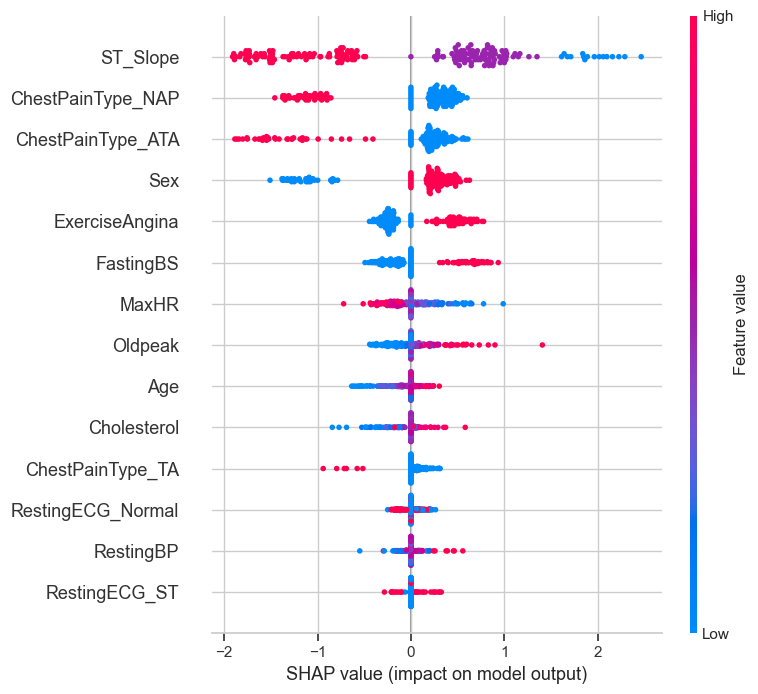

In [26]:
# Global feature importance
shap_values_global = explainer.shap_values(X_test)
shap.summary_plot(shap_values_global, X_test, feature_names=X.columns)


In [27]:
# Compare top features across samples
top_feats = [np.argsort(np.abs(shap_values[i]))[::-1][:3] for i in range(len(shap_values))]
for i, feats in enumerate(top_feats):
    print(f"Top features for sample {i}: {[X.columns[j] for j in feats]}")


Top features for sample 0: ['ST_Slope', 'ExerciseAngina', 'Sex']
Top features for sample 1: ['ChestPainType_NAP', 'ST_Slope', 'Oldpeak']
Top features for sample 2: ['Sex', 'ChestPainType_NAP', 'Age']
Top features for sample 3: ['ST_Slope', 'ChestPainType_NAP', 'MaxHR']


### Explanation:
By comparing the top 3 most influential features across our 4 individual samples, we observe that certain features (e.g., chol, age, thalach) appear repeatedly, suggesting some consistency in local explanations. However, there is still variation — different samples emphasize different features depending on their individual values and interactions. When comparing these local importances to the global SHAP summary plot, we see partial overlap: features like chol and thalach may appear both globally and locally, but not always in the same order. This illustrates that while some features are consistently important, SHAP explanations adapt to individual cases, making them both locally accurate and globally interpretable.

---

# Q4 - Neural Additive Models
### Q4.1 - NAM Architecture

In [49]:
n_features = X_train.shape[1]
feature_names = X.columns.tolist()

# create one Input & subnet per feature
inputs = []
outputs = []
for i, name in enumerate(feature_names):
    inp = Input(shape=(1,), name=f"inp_{name}")
    x = Dense(32, activation='relu', name=f"dense1_{name}")(inp)
    x = Dense(16, activation='relu', name=f"dense2_{name}")(x)
    out = Dense(1, activation=None, name=f"shape_{name}")(x)
    inputs.append(inp)
    outputs.append(out)

# sum all feature sub‑net outputs + bias
combined = Add(name="sum_features")(outputs)
prob = Activation('sigmoid', name="prediction")(combined)

# assemble model
nam = Model(inputs=inputs, outputs=prob, name="NeuralAdditiveModel")
nam.compile(optimizer=Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Prepare inputs as list of single‑column arrays
def to_feature_list(X_array):
    return [X_array[:, i].reshape(-1,1) for i in range(X_array.shape[1])]

X_train_list = to_feature_list(X_train)
X_test_list  = to_feature_list(X_test)

#### Training

In [50]:
history = nam.fit(
    X_train_list, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.5841 - loss: 0.6675 - val_accuracy: 0.7297 - val_loss: 0.5557
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8153 - loss: 0.4422 - val_accuracy: 0.7703 - val_loss: 0.5289
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8332 - loss: 0.3803 - val_accuracy: 0.7973 - val_loss: 0.5206
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8232 - loss: 0.3679 - val_accuracy: 0.7973 - val_loss: 0.5231
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8320 - loss: 0.3555 - val_accuracy: 0.7838 - val_loss: 0.5222
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8262 - loss: 0.3615 - val_accuracy: 0.7973 - val_loss: 0.5293
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8444 - loss: 0.3414 - val_accuracy: 0.7973 - val_loss: 0.5311
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8541 - loss: 0.3363 - val_accuracy: 0.7838 - 

#### Evaluation

In [51]:
y_pred_proba = nam.predict(X_test_list).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Test Accuracy:          ", accuracy_score(y_test, y_pred))
print("Test F1 Score:          ", f1_score(y_test, y_pred))
print("Test Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Test Accuracy:           0.8804347826086957
Test F1 Score:           0.89
Test Balanced Accuracy:  0.8813964610234337

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.89      0.87        82
         1.0       0.91      0.87      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



---
### Q4.2 - Visualize Feature Importance

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


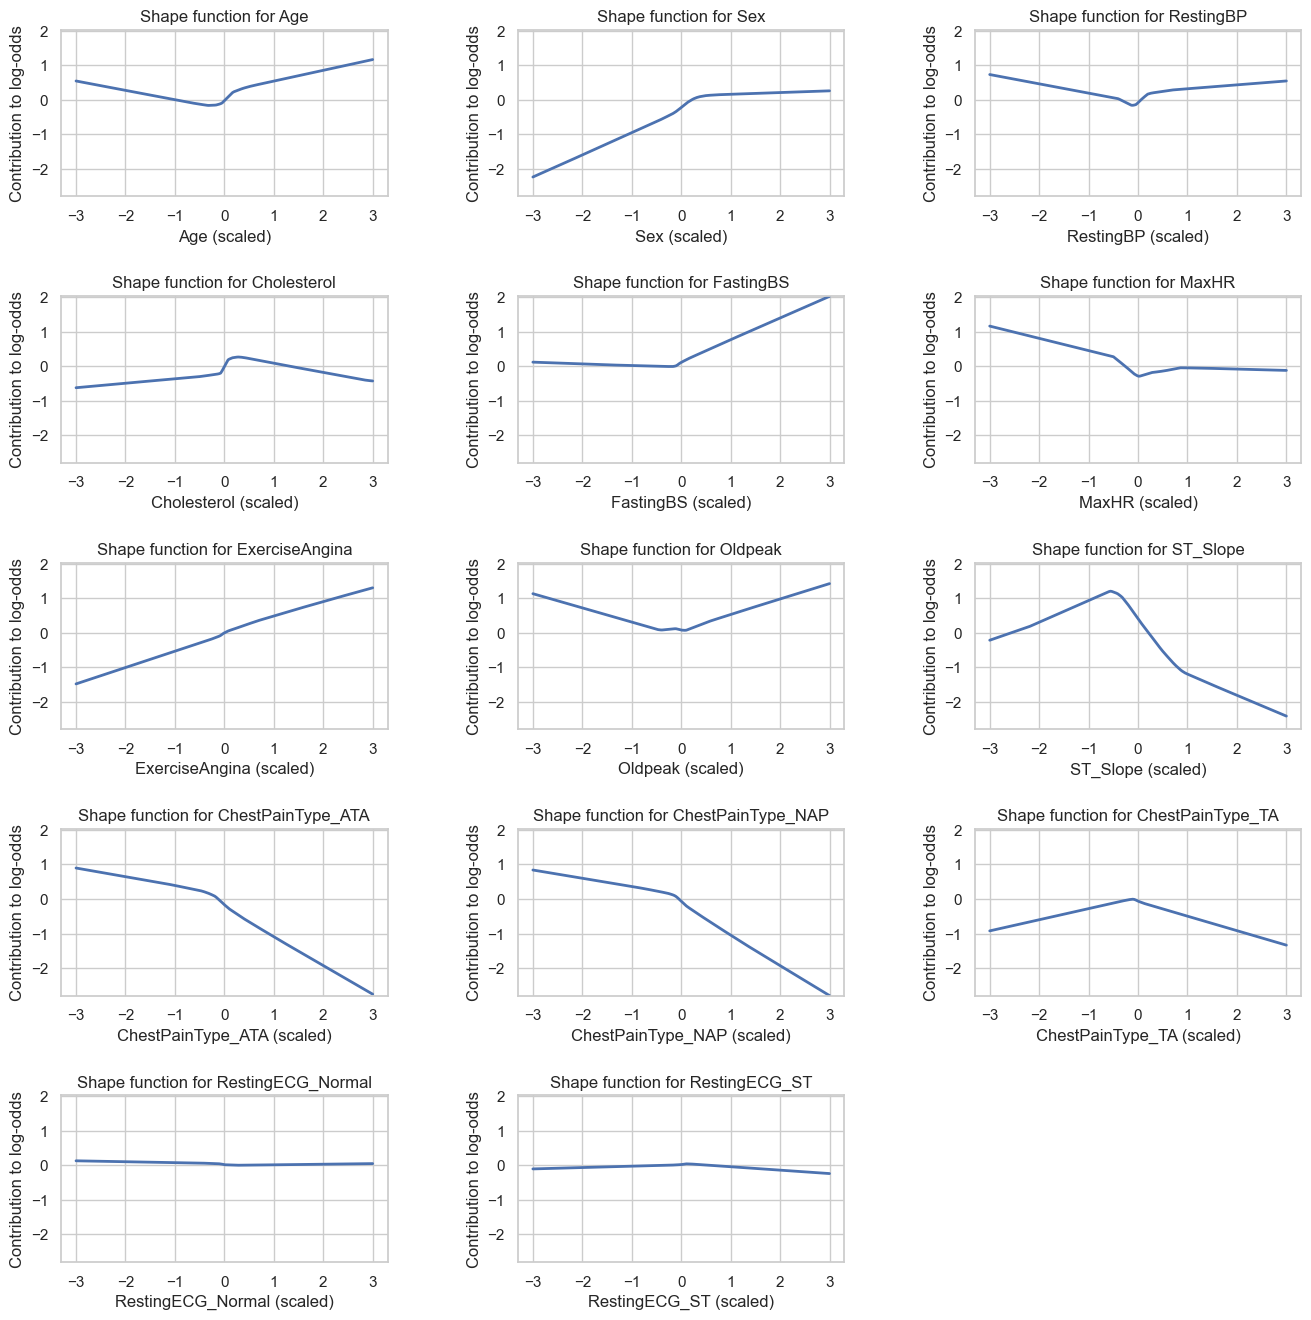

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model

# 1) precompute all the shape-values
grid = np.linspace(-3, 3, 200)
shape_vals = []
for idx, name in enumerate(feature_names):
    X_batch = np.zeros((len(grid), len(feature_names)))
    X_batch[:, idx] = grid
    X_list  = to_feature_list(X_batch)

    shape_model = Model(inputs=nam.inputs,
                        outputs=nam.get_layer(f"shape_{name}").output)
    vals = shape_model.predict(X_list).ravel()
    shape_vals.append(vals)

ymin = min(v.min() for v in shape_vals)
ymax = max(v.max() for v in shape_vals)

# 2) create plot
fig, axes = plt.subplots(
    nrows=5, ncols=3,
    figsize=(16, 16),
    gridspec_kw={
        "hspace": 0.6,   # increase the height padding between rows
        "wspace": 0.4    # (optional) loosen columns too
    }
)

axes = axes.flatten()
for idx, name in enumerate(feature_names):
    ax   = axes[idx]
    vals = shape_vals[idx]

    ax.plot(grid, vals, lw=2)
    ax.set_title(f"Shape function for {name}")
    ax.set_xlabel(f"{name} (scaled)")
    ax.set_ylabel("Contribution to log-odds")
    ax.set_ylim(ymin, ymax)
    ax.grid(True)

# turn off any unused subplots
for ax in axes[len(feature_names):]:
    ax.axis("off")

plt.show()


---
## Q4.3
The Neural Additive Model combines the interpretability of Logistic Regression with the expressive power of neural networks. Unlike Logistic Regression, NAM models each feature’s effect non-linearly using a small subnetwork, enabling it to capture richer individual feature patterns. Compared to MLPs, NAM avoids feature interactions and enforces additive structure, making it significantly more interpretable while sacrificing some predictive complexity.

---
## Q4.4
NAMs are more interpretable than MLPs because they enforce an additive structure over individual features, where each feature is passed through its own isolated subnetwork that models a univariate function. This design means the effect of each feature on the prediction can be visualized independently using a shape function, showing exactly how the feature contributes to the model’s output. In contrast, MLPs entangle all features through dense layers, making it difficult to attribute prediction behavior to specific inputs. Even though both use non-linear neural networks, NAMs retain transparency by structuring non-linearity in a feature-wise decomposable way.